# DeepSeedlings: CNN
Using pre-trained Tensorflow CNNs (with the last layer 'cut' off) to vectorize images.

In [1]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import cv2
import seaborn as sns
import keras
from keras import backend as K
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
#from sklearn.cross_validation import train_test_split
#from tqdm import tqdm
import pickle

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_train_valid_bf = np.load(os.path.join(os.getcwd(),'x_train_valid_bf.npy'))
y_train_valid = np.load(os.path.join(os.getcwd(),'y_train_valid.npy'))

In [3]:
x_test_bf = np.load(os.path.join(os.getcwd(),'x_test_bf.npy'))

# Prep Train/Validation Data
- shuffle
- train/validation split

In [4]:
# use one-hot encoding for categorial labels
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

# function to shuffle randomly train and validation data
def shuffle_train_valid_data(x_train_valid):
    
    print('shuffle train and validation data')
    
    # shuffle train and validation data of original data
    perm_array = np.arange(len(x_train_valid)) 
    np.random.shuffle(perm_array)
    
    # split train and validation sets based on original data
    x_train = x_train_valid[perm_array[:train_set_size]]
    y_train = dense_to_one_hot(y_train_valid[perm_array[:train_set_size]], num_classes = 12)
    x_valid = x_train_valid[perm_array[-valid_set_size:]]
    y_valid = dense_to_one_hot(y_train_valid[perm_array[-valid_set_size:]], num_classes = 12)
         
    return x_train, y_train, x_valid, y_valid 

In [5]:
# split into train and validation sets
valid_set_size_percentage = 10
valid_set_size = int(len(x_train_valid_bf) * valid_set_size_percentage/100);
train_set_size = len(x_train_valid_bf) - valid_set_size

In [6]:
# shuffle and train/validation split
x_train_bf, y_train, x_valid_bf, y_valid = shuffle_train_valid_data(x_train_valid_bf) 

shuffle train and validation data


In [7]:
print('x_train_bf.shape = ', x_train_bf.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid_bf.shape = ', x_valid_bf.shape)
print('y_valid.shape = ', y_valid.shape)

x_train_bf.shape =  (2160, 2048)
y_train.shape =  (2160, 12)
x_valid_bf.shape =  (240, 2048)
y_valid.shape =  (240, 12)


In [8]:
from keras import backend as K

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))




In [9]:
# lr decay schedule
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 0.0001
    if epoch > 20 :
        lr *= 1e-1
    #elif epoch > 15 :
    #    lr *= 1e-2

    print('Learning rate: ', lr)
    return lr

## Xception CNN  with additional layers
(best results)

In [10]:
x_size = x_train_bf.shape[1] # features 
y_size = 12

In [11]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
#model.add(x_conv)
 
# Add new layers
#model.add(layers.Flatten())
model.add(layers.Dense(1024, input_dim = x_size, activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(12, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                3084      
Total params: 2,363,660
Trainable params: 2,363,660
Non-trainable params: 0
_________________________________________________________________


In [12]:
1e-4

0.0001

In [13]:
# Callbacks
tensorboard = TensorBoard(log_dir = './logs')

checkpointer = ModelCheckpoint(filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)


# Compile the model


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr_schedule(0)),
              metrics=['acc', precision, recall, f1])

lr = LearningRateScheduler(lr_schedule)
# Train the model

 
history = model.fit(x=x_train_bf, y=y_train,  epochs=40, verbose=1, validation_data=(x_valid_bf, y_valid), callbacks = [tensorboard, checkpointer, lr])
                    #callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, 
                    #class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)
# Save the model
#model.save('small_last4.h5')

Learning rate:  0.0001
Train on 2160 samples, validate on 240 samples
Epoch 1/40
Learning rate:  0.0001
2160/2160 [==============================] - 1s 304us/step - loss: 1.7636 - acc: 0.4569 - precision: 0.4144 - recall: 0.0449 - f1: nan - val_loss: 1.0692 - val_acc: 0.7125 - val_precision: 0.9376 - val_recall: 0.2542 - val_f1: 0.3967

Epoch 00001: val_loss improved from inf to 1.06919, saving model to /tmp/weights.01-1.07.hdf5
Epoch 2/40
Learning rate:  0.0001
2160/2160 [==============================] - 0s 191us/step - loss: 1.0155 - acc: 0.6880 - precision: 0.8474 - recall: 0.3958 - f1: 0.5285 - val_loss: 0.7325 - val_acc: 0.7500 - val_precision: 0.8688 - val_recall: 0.6083 - val_f1: 0.7141

Epoch 00002: val_loss improved from 1.06919 to 0.73254, saving model to /tmp/weights.02-0.73.hdf5
Epoch 3/40
Learning rate:  0.0001
2160/2160 [==============================] - 0s 190us/step - loss: 0.7456 - acc: 0.7551 - precision: 0.8456 - recall: 0.6097 - f1: 0.7057 - val_loss: 0.5484 - val_

2160/2160 [==============================] - 0s 193us/step - loss: 0.0932 - acc: 0.9764 - precision: 0.9796 - recall: 0.9745 - f1: 0.9770 - val_loss: 0.2773 - val_acc: 0.9083 - val_precision: 0.9197 - val_recall: 0.9000 - val_f1: 0.9096

Epoch 00025: val_loss did not improve
Epoch 26/40
Learning rate:  1e-05
2160/2160 [==============================] - 0s 190us/step - loss: 0.0940 - acc: 0.9755 - precision: 0.9817 - recall: 0.9694 - f1: 0.9754 - val_loss: 0.2762 - val_acc: 0.9125 - val_precision: 0.9238 - val_recall: 0.9042 - val_f1: 0.9138

Epoch 00026: val_loss did not improve
Epoch 27/40
Learning rate:  1e-05
2160/2160 [==============================] - 0s 191us/step - loss: 0.0936 - acc: 0.9759 - precision: 0.9785 - recall: 0.9718 - f1: 0.9751 - val_loss: 0.2778 - val_acc: 0.9083 - val_precision: 0.9161 - val_recall: 0.9042 - val_f1: 0.9101

Epoch 00027: val_loss did not improve
Epoch 28/40
Learning rate:  1e-05
2160/2160 [==============================] - 0s 196us/step - loss: 0.0

In [14]:
model.save('xception_seedlings.h5')

# Results

In [15]:
y_valid_predict_proba = model.predict(x_valid_bf, verbose =1)

240/240 [==============================] - 0s 124us/step


In [16]:
y_valid_predict_species = []
for pred in y_valid_predict_proba:
    y_valid_predict_species.append(np.argmax(pred))

In [17]:
cnf_matrix = confusion_matrix(one_hot_to_dense(y_valid), y_valid_predict_species)

In [18]:
cnf_matrix

array([[14,  0,  0,  0,  1,  0,  6,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 22,  0,  0,  0,  0,  0,  0],
       [ 5,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 26,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  2, 25,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0, 17]])

In [19]:
print(classification_report(one_hot_to_dense(y_valid), y_valid_predict_species))

             precision    recall  f1-score   support

          0       0.74      0.67      0.70        21
          1       0.90      1.00      0.95        19
          2       0.95      0.95      0.95        22
          3       1.00      0.95      0.98        21
          4       0.94      1.00      0.97        17
          5       0.96      1.00      0.98        22
          6       0.67      0.71      0.69        17
          7       0.93      0.96      0.95        27
          8       0.87      1.00      0.93        13
          9       1.00      0.89      0.94        28
         10       1.00      1.00      1.00        14
         11       1.00      0.89      0.94        19

avg / total       0.92      0.92      0.92       240



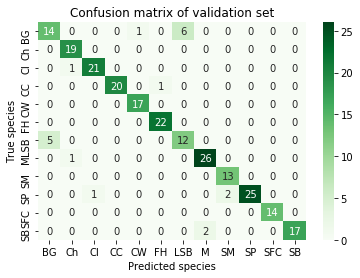

In [20]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']


fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of validation set')
plt.ylabel('True species')
plt.xlabel('Predicted species')
plt.show();

# Try retraining part of XCeption

In [21]:
x_train_valid = np.load(os.path.join(os.getcwd(),'x_train_valid_imgs.npy'))
y_train_valid = np.load(os.path.join(os.getcwd(),'y_train_valid.npy'))
x_test = np.load(os.path.join(os.getcwd(),'x_test_imgs.npy'))

In [22]:
# split into train and validation sets
valid_set_size_percentage = 10
valid_set_size = int(len(x_train_valid) * valid_set_size_percentage/100);
train_set_size = len(x_train_valid) - valid_set_size

In [23]:
# shuffle and train/validation split
x_train, y_train, x_valid, y_valid = shuffle_train_valid_data(x_train_valid) 

shuffle train and validation data


In [24]:
x_conv = xception.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling = 'avg')

In [25]:
## Freeze the layers except the last 4 layers
for layer in x_conv.layers[:-4]:
    layer.trainable = False
 
## Check the trainable status of the individual layers
#for layer in x_conv.layers:
#    print(layer, layer.trainable)

In [26]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(x_conv)
 
# Add new layers
#model.add(layers.Flatten())
model.add(layers.Dense(1024,  activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.33))
model.add(layers.Dense(12, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                3084      
Total params: 23,225,140
Trainable params: 5,527,308
Non-trainable params: 17,697,832
________________________________________________________

In [27]:
# Callbacks
tensorboard = TensorBoard(log_dir = './logs')

checkpointer = ModelCheckpoint(filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)


# Compile the model


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr_schedule(0)),
              metrics=['acc', precision, recall, f1])

lr = LearningRateScheduler(lr_schedule)
# Train the model

 
history = model.fit(x=x_train, y=y_train,  epochs=40, verbose=1, validation_data=(x_valid, y_valid), callbacks = [tensorboard, checkpointer, lr])
                    #callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, 
                    #class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)
# Save the model
#model.save('small_last4.h5')

Learning rate:  0.0001
Train on 2160 samples, validate on 240 samples
Epoch 1/40
Learning rate:  0.0001
2160/2160 [==============================] - 50s 23ms/step - loss: 1.7833 - acc: 0.4736 - precision: 0.4815 - recall: 0.0713 - f1: nan - val_loss: 1.7510 - val_acc: 0.3958 - val_precision: 0.3758 - val_recall: 0.1333 - val_f1: nan

Epoch 00001: val_loss improved from inf to 1.75095, saving model to /tmp/weights.01-1.75.hdf5
Epoch 2/40
Learning rate:  0.0001
  64/2160 [..............................] - ETA: 41s - loss: 1.1606 - acc: 0.7656 - precision: 0.9583 - recall: 0.2812 - f1: 0.4295

KeyboardInterrupt: 